In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../SETPOINT/')
from process.config import REFERENCE_INTERVALS
from model.utils import *

inv_vocab = {v: k for k, v in TEST_VOCAB.items()}


In [3]:
def calculate_model_metrics(models):
    all_agg_metrics = []
    all_metrics = []
    
    for model_name, (path, y_col, pred_col) in models.items():
        df = pd.read_csv(path)
        
        metrics = df.groupby(['split', 'cid']).apply(
            lambda g: pd.Series({
                'Model': model_name,
                'Split': g['split'].iloc[0].title(),
                'Code': inv_vocab[g['cid'].iloc[0]],
                'MAE': mean_absolute_error(g[y_col], g[pred_col]), 
                'R2': r2_score(g[y_col], g[pred_col]),
                'MSE': mean_squared_error(g[y_col], g[pred_col])
            })
        ).reset_index(drop=True)
        
        # Aggregate metrics
        metrics_to_agg = ['MAE', 'R2', 'MSE']
        agg_metrics = metrics.groupby('Split').agg({
            metric: ['mean', 'std'] for metric in metrics_to_agg
        }).round(1)
        
        agg_metrics.columns = pd.MultiIndex.from_product([metrics_to_agg, ['mean', 'std']])
        agg_metrics['Model'] = model_name
        
        all_agg_metrics.append(agg_metrics)
        all_metrics.append(metrics)
    
    return (
        pd.concat(all_agg_metrics),
        pd.concat(all_metrics)
    )

def print_formatted_metrics(all_metrics):
    metrics_to_display = ['MAE', 'R2', 'MSE']  
    splits = ['Train', 'Val', 'Test']  
    
    for split in splits:
        split_metrics = all_metrics.loc[split]
        
        formatted = pd.DataFrame(
            index=metrics_to_display,
            data={
                model: {
                    metric: f"{row[metric]['mean'].iloc[0]:.1f} ± {row[metric]['std'].iloc[0]:.1f}"
                    for metric in metrics_to_display
                }
                for model, row in split_metrics.groupby('Model')
            }
        )
        
        print(f"\nMetrics for {split} split:")
        display(formatted)


In [46]:
models = {
    'Baseline': ('ARIMA/predictions/mean_baseline_predictions.csv', 'x_next', 'mu'),
    'ARIMA': ('ARIMA/predictions/arima_baseline_predictions.csv', 'true_next_value', 'prediction'),
    'NormaLight': ('model/predictions/ce786a63/predictions_ce786a63.csv', 'x_next', 'mu'),
    'NormaLightBalanced': ('model/predictions/ce786a63/predictions_ce786a63.csv', 'x_next', 'mu'),
    'NormaAdaptive': ('../SETPOINT/models/norma/predictions/single_mode_20250815_102638/all_predictions_single_mode_20250815_102638.csv', 'target', 'prediction'),
}

all_metrics, all_code_metrics = calculate_model_metrics(models)
print_formatted_metrics(all_metrics)



Metrics for Train split:


,ARIMA,Baseline,NormaAdaptive,NormaLight,NormaLightBalanced
MAE,7.2 ± 10.3,9.9 ± 14.6,10.3 ± 17.7,11.1 ± 20.2,11.1 ± 20.2
R2,0.6 ± 0.2,0.4 ± 0.2,0.4 ± 0.3,0.3 ± 0.5,0.3 ± 0.5
MSE,531.3 ± 1002.3,916.8 ± 1874.5,1104.0 ± 2634.9,1323.9 ± 3370.7,1323.9 ± 3370.7



Metrics for Val split:


,ARIMA,Baseline,NormaAdaptive,NormaLight,NormaLightBalanced
MAE,7.7 ± 11.9,10.4 ± 15.8,9.5 ± 17.0,12.0 ± 22.2,12.0 ± 22.2
R2,0.6 ± 0.2,0.4 ± 0.2,0.4 ± 0.3,0.3 ± 0.5,0.3 ± 0.5
MSE,875.5 ± 2515.0,1022.9 ± 2202.2,899.4 ± 2400.4,1584.3 ± 4038.9,1584.3 ± 4038.9



Metrics for Test split:


,ARIMA,Baseline,NormaAdaptive,NormaLight,NormaLightBalanced
MAE,7.8 ± 12.4,10.7 ± 17.4,12.0 ± 21.2,12.4 ± 23.4,12.4 ± 23.4
R2,0.6 ± 0.2,0.4 ± 0.1,0.4 ± 0.3,0.3 ± 0.5,0.3 ± 0.5
MSE,828.2 ± 2427.1,1303.1 ± 3569.7,1364.5 ± 3136.6,1712.9 ± 4313.8,1712.9 ± 4313.8


In [47]:
# # Read predictions for NormaAdaptive model
# train = pd.read_csv('../SETPOINT/models/norma/predictions/single_mode_20250815_102638/train_predictions_single_mode_20250815_102638.csv')
# val = pd.read_csv('../SETPOINT/models/norma/predictions/single_mode_20250815_102638/val_predictions_single_mode_20250815_102638.csv')
# test = pd.read_csv('../SETPOINT/models/norma/predictions/single_mode_20250815_102638/test_predictions_single_mode_20250815_102638.csv')

# # Add split column to each dataframe before concatenating
# train['split'] = 'train'
# val['split'] = 'val' 
# test['split'] = 'test'
# display(train)
# # Combine into single dataframe
# df = pd.concat([train, val, test], ignore_index=True)
# df['cid'] = df['test_name'].map(TEST_VOCAB)
# df.rename(columns={'test_name': 'code'}, inplace=True)
# # save the dataframe
# df.to_csv('../SETPOINT/models/norma/predictions/single_mode_20250815_102638/all_predictions_single_mode_20250815_102638.csv', index=False)


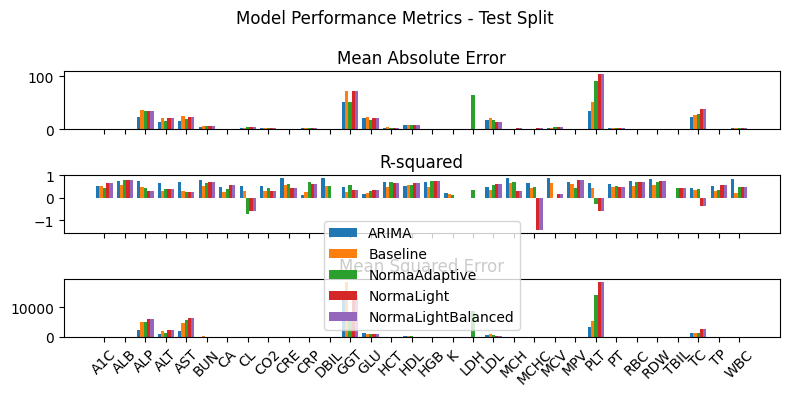

In [ ]:
def plot_metrics_by_split(metrics_df, split='Test'):
    """
    Plot MAE, R2, and MSE metrics for each model for a specific split.
    
    Args:
        metrics_df: DataFrame containing metrics for all models
        split: Which split to plot ('Test', 'Train', or 'Val')
    """
    # Filter for specified split
    split_metrics = metrics_df[metrics_df['Split'] == split]

    # Get unique models and codes, ensure consistent ordering
    models = sorted(split_metrics['Model'].unique())
    codes = sorted(split_metrics['Code'].unique())
    
    # Create figure with 3 subplots stacked vertically
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
    fig.suptitle(f'Model Performance Metrics - {split} Split')
    
    # Plot settings
    width = 0.8 / len(models)
    x = np.arange(len(codes))
    
    # Plot MAE
    for i, model in enumerate(models):
        model_data = split_metrics[split_metrics['Model'] == model]
        # Ensure data aligns with codes by merging
        model_data = pd.merge(pd.DataFrame({'Code': codes}), 
                            model_data,
                            on='Code',
                            how='left').fillna(0)
        offset = width * (i - (len(models)-1)/2)
        ax1.bar(x + offset, model_data['MAE'], width, label=model)
    
    ax1.set_title('Mean Absolute Error')
    ax1.set_xticks(x)
    ax1.set_xticklabels(codes, rotation=45)
    
    # Plot R2
    for i, model in enumerate(models):
        model_data = split_metrics[split_metrics['Model'] == model]
        # Ensure data aligns with codes by merging
        model_data = pd.merge(pd.DataFrame({'Code': codes}), 
                            model_data,
                            on='Code',
                            how='left').fillna(0)
        offset = width * (i - (len(models)-1)/2)
        ax2.bar(x + offset, model_data['R2'], width, label=model)
    
    ax2.set_title('R-squared')
    ax2.set_xticks(x)
    ax2.set_xticklabels(codes, rotation=45)
    
    # Plot MSE
    for i, model in enumerate(models):
        model_data = split_metrics[split_metrics['Model'] == model]
        # Ensure data aligns with codes by merging
        model_data = pd.merge(pd.DataFrame({'Code': codes}), 
                            model_data,
                            on='Code',
                            how='left').fillna(0)
        offset = width * (i - (len(models)-1)/2)
        ax3.bar(x + offset, model_data['MSE'], width, label=model)
    
    ax3.set_ylabel('Mean Squared Error')
    ax3.set_xticks(x)
    ax3.set_xticklabels(codes, rotation=45)
    ax3.legend()
    
    plt.tight_layout()
    return fig

# Example usage
test = plot_metrics_by_split(all_code_metrics, split='Test')
